# Installing Required Packages and Importing

In [1]:
!pip install torch torchvision --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
from tqdm import tqdm

In [3]:
print(torch.__version__)

2.7.0+cu126


# Download and Load Dataset


In [4]:
# Load training and test datasets
example_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=None)

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


# Exploring Individual Augmentations

## Visualize Base Image

In [5]:
def imshow(img, title=None):
    plt.imshow(img)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

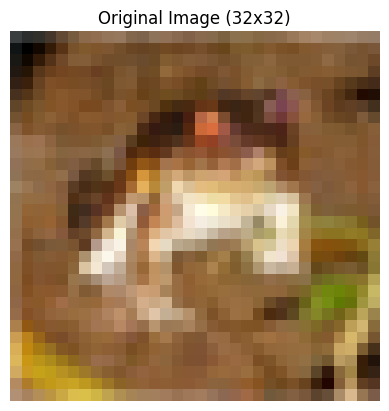

In [6]:
original_img = example_dataset[0][0]  # First training image
imshow(original_img, "Original Image (32x32)")

## Random Cropping (with Padding) and Horizontal Reflection

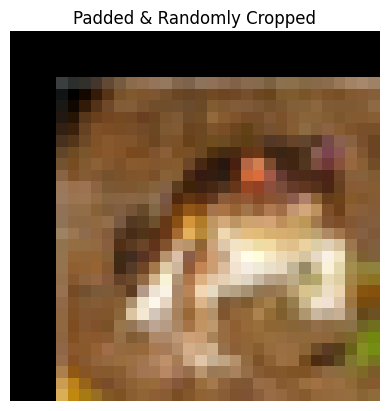

In [7]:
transform_pad_crop = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32)
])

cropped_img = transform_pad_crop(original_img)
imshow(cropped_img, "Padded & Randomly Cropped")

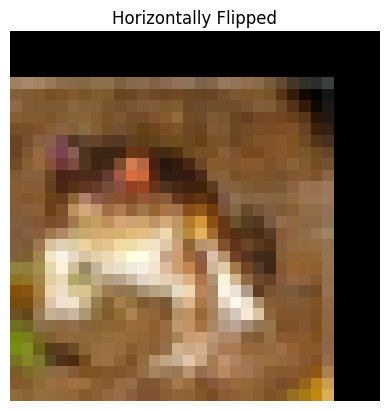

In [8]:
transform_flip = transforms.RandomHorizontalFlip(p=1)
flipped_img = transform_flip(cropped_img)
imshow(flipped_img, "Horizontally Flipped")

## Color Transformations

### Basic Color Jitter (Not Implemented in Final Transformation Pipeline )

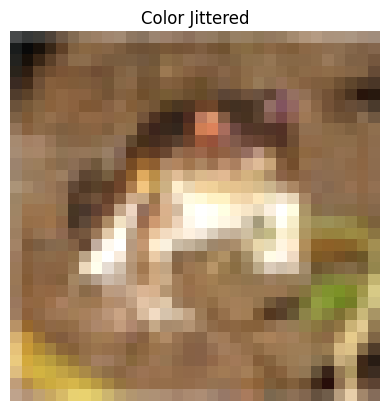

In [9]:
transform_color = transforms.ColorJitter(
    brightness=0.3,
    contrast=0.3,
    saturation=0.3
)

jittered_img = transform_color(original_img)
imshow(jittered_img, "Color Jittered")

### PCA-Based Color Jitter (AlexNet Original)

#### Compute Dataset Statistics to Analyze Color Correlations

In [10]:
# Compute PCA components for CIFAR-10
pixels = []
for img, _ in example_dataset:
    pixels.append(np.array(img))
pixels = np.array(pixels)

# Calculate mean and covariance matrix
mean = np.mean(pixels, axis=(0, 1, 2))
pixels_centered = pixels - mean

# Reshape to (num_pixels, 3) for covariance calculation
h, w, c = pixels.shape[1], pixels.shape[2], pixels.shape[3]
pixels_flat = pixels_centered.reshape(-1, 3)

# Compute covariance matrix and eigenvectors
cov = np.cov(pixels_flat.T)
#eigvals, eigvecs = np.linalg.eig(cov)
eigvals, eigvecs = np.linalg.eigh(cov)

# Sort eigenvalues in descending order
sort_idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[sort_idx]
eigvecs = eigvecs[:, sort_idx]

# print(pixels, mean, cov, eigvals, eigvecs)

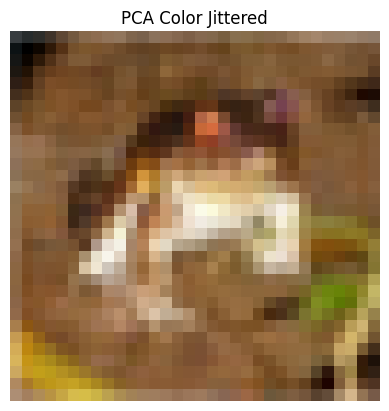

In [14]:
class PCAColorJitter:
    def __init__(self, eigvecs, eigvals, alpha=0.1):
        self.eigvecs = eigvecs
        self.eig_std = np.sqrt(np.maximum(np.real(eigvals), 0))
        self.alpha = alpha

    def __call__(self, img):
        img_arr = np.array(img, dtype=np.float32)
        perturb = self.alpha * np.random.randn(3)
        delta = (self.eigvecs @ (self.eig_std * perturb)).reshape(1, 1, 3)
        img_jittered = np.clip(img_arr + delta, 0, 255)
        return Image.fromarray(img_jittered.astype('uint8'))

pca_jitter = PCAColorJitter(eigvecs, eigvals)
pca_img = pca_jitter(original_img)
imshow(pca_img, "PCA Color Jittered")

## Normalization

### Calculating CIFAR-10 Mean and Standard Deviation

In [ ]:
# Initialize accumulators
channel_sum = torch.zeros(3)
channel_sq_sum = torch.zeros(3)
num_pixels = 0

# Convert all images to tensors and accumulate stats
for img, _ in tqdm(example_dataset, desc="Calculating stats"):
    img_tensor = transforms.ToTensor()(img)  # Converts to [0,1] range
    channel_sum += img_tensor.sum(dim=[1, 2])  # Sum over H and W dimensions
    channel_sq_sum += (img_tensor ** 2).sum(dim=[1, 2])
    num_pixels += img_tensor.shape[1] * img_tensor.shape[2]

# Calculate final mean and std
dataset_mean = channel_sum / num_pixels
dataset_std = torch.sqrt((channel_sq_sum / num_pixels) - (dataset_mean ** 2))

print(f"Calculated Mean: {dataset_mean.tolist()}")
print(f"Calculated Std: {dataset_std.tolist()}")

In [ ]:
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

### Denormalization Check

In [ ]:
# Visualization with inverse transform
def denormalize(tensor):
    inv_normalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(dataset_mean, dataset_std)],
        std=[1/s for s in dataset_std]
    )
    denorm_tensor = inv_normalize(tensor.clone())
    return denorm_tensor.permute(1, 2, 0).clamp(0, 1)

# Test with sample image
original_img = example_dataset[0][0]
normalized_tensor = transform_normalize(original_img)

# Visual comparison
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(original_img)
plt.title("Original Image")

plt.subplot(122)
plt.imshow(denormalize(normalized_tensor))
plt.title("Normalized & Denormalized")
plt.show()

# Combined Augmentation Pipeline

In [ ]:
train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(0.2, 0.2, 0.2),
    PCAColorJitter(eigvecs, eigvals),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std)
])

# Apply to dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

In [ ]:
# Train-Validation Dataset Split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=100, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Define AlexNet Arch

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=2),  # Adjusted for 32x32
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training, Validation and Results

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization
model = AlexNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')

    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        pbar.set_postfix({'Loss': loss.item(), 'Acc': 100.*correct/total})

    # Return average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Return average loss and accuracy
    avg_loss = val_loss / len(val_loader)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
for epoch in range(1, 50):
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    val_loss, val_acc = val(model, device, val_loader)
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print epoch summary
    print(f'Epoch {epoch}: '
          f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}%')


In [ ]:
test_loss, test_acc = val(model, device, test_loader)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')

In [ ]:
# Learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
torch.save({
    'epoch': len(train_losses),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
}, './alexnet_cifar10.pth')